<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#20-news-groups-load" data-toc-modified-id="20-news-groups-load-1">20 news groups load</a></span></li><li><span><a href="#Spectral-Clustering" data-toc-modified-id="Spectral-Clustering-2">Spectral Clustering</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3">PCA</a></span></li><li><span><a href="#SPECTRAL" data-toc-modified-id="SPECTRAL-4">SPECTRAL</a></span></li><li><span><a href="#SPECTRAL-V2" data-toc-modified-id="SPECTRAL-V2-5">SPECTRAL V2</a></span></li></ul></div>

# 20 news groups load

In [660]:
import spectral
import scipy
from scipy import sparse
import numpy as np
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))

from sklearn import preprocessing, decomposition, model_selection

In [661]:
from sklearn import metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [662]:
all_news = fetch_20newsgroups(subset='all')

In [831]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, sublinear_tf=True, max_features=500)

In [832]:
news_data = vectorizer.fit_transform(all_news.data)
news_target = all_news.target
news_target_names = all_news.target_names 

feature_names = vectorizer.get_feature_names()

In [833]:
news_data.shape, news_target.shape

((18846, 500), (18846,))

In [834]:
news_target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [835]:
targets = [0, 1, 7, 11]

In [836]:
mask = np.zeros_like(news_target, dtype=bool)
label_to_name = {}

for t in targets:
    name = news_target_names[t]
    label_to_name[t] = name
    print(name)
    mask = mask | (news_target == t)

alt.atheism
comp.graphics
rec.autos
sci.crypt


In [837]:
labels = news_target[mask]

In [838]:
mask.sum(), mask.shape

(3753, (18846,))

In [839]:
set(news_target)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

# Spectral Clustering

In [840]:
features = scipy.sparse.csr_matrix.todense(news_data)[mask]

In [841]:
print(np.count_nonzero(features == np.nan))

0


In [842]:
distances = spectral.features_to_dist_matrix(features, metric='cosine')

if np.count_nonzero(np.isnan(distances)) > 0 or np.min(distances) == np.nan:
    print('there are some nan')
    distances = np.nan_to_num(distances, copy=False)

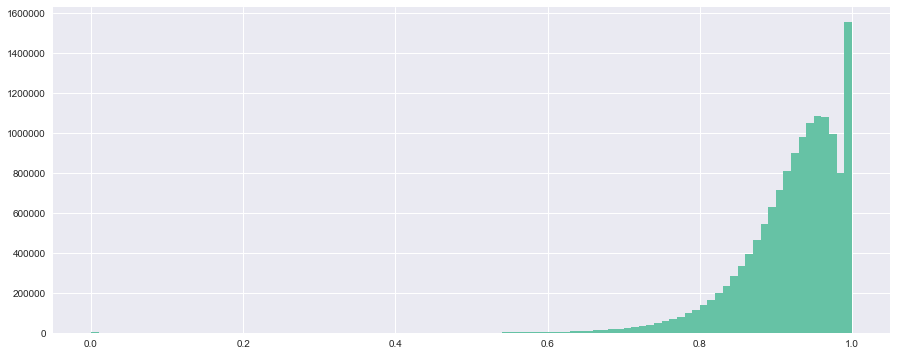

In [843]:
plt.hist(np.nan_to_num(distances, copy=True).flatten(), bins=100);

In [844]:
print('{} distances equal exactly zero.'.format(np.sum(distances == 0)))

3753 distances equal exactly zero.


In [875]:
all_weights = spectral.dist_to_adj_matrix(distances, 'gaussian')

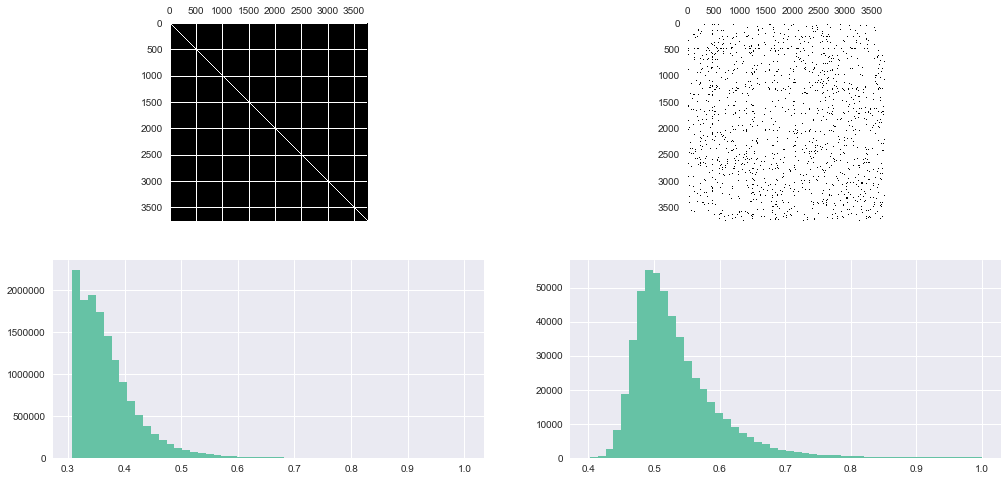

In [876]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);

NEIGHBORS = 100
weights = spectral.filter_neighbors(all_weights, NEIGHBORS)

plot(all_weights, axes[:, 0])
plot(weights, axes[:, 1])

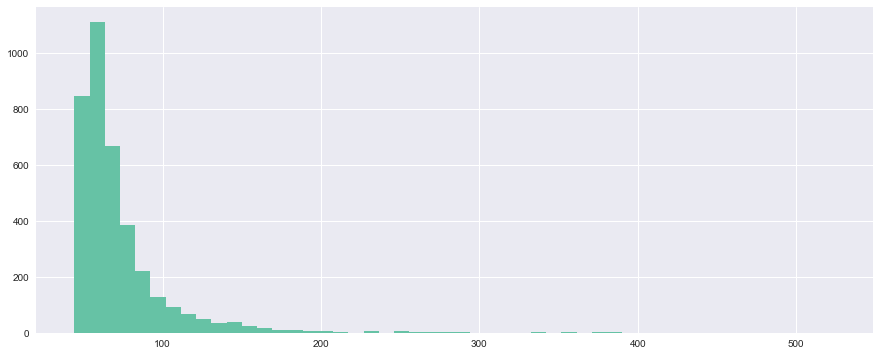

In [877]:
# Weighted degree distribution
degrees = np.sum(weights, axis=0)

plt.hist(degrees, bins=50);

In [871]:
D = np.diag(degrees)
W = weights
L = D - W

inv_sqrt_D = np.diag(1 / np.diag(D**(0.5)))

normalized_laplacian = inv_sqrt_D @ L @ inv_sqrt_D

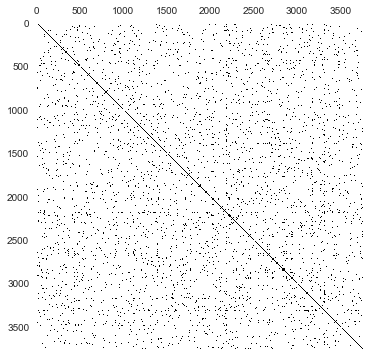

In [872]:
plt.spy(normalized_laplacian);

In [873]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(normalized_laplacian, k=20, which='SM') # which='SA' gives us similar results

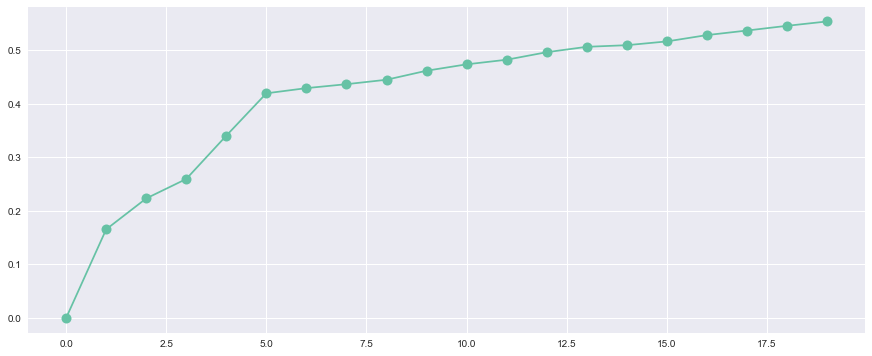

In [874]:
plt.plot(eigenvalues, '.-', markersize=20);

In [852]:
G = nx.from_numpy_matrix(L)
gc = max(nx.connected_component_subgraphs(G), key=len)

In [853]:
assert len(gc.nodes()) == weights.shape[0], "GCC should contain all nodes"

# PCA

In [854]:
features_pca = decomposition.PCA(n_components=3).fit_transform(features)

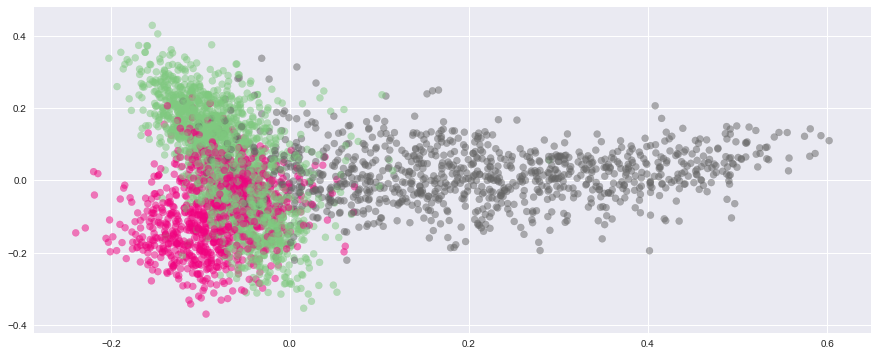

In [855]:
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='Accent', alpha=0.5);

# SPECTRAL

-13854 errors (-369.14%)


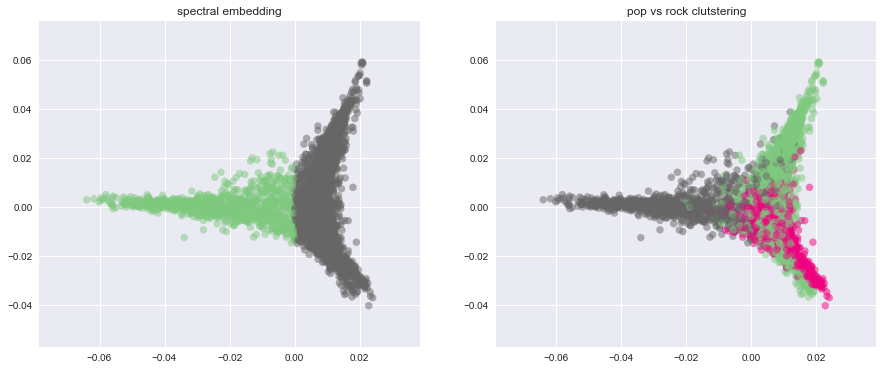

In [856]:
spectral.compare_plot_labels(eigenvectors, labels)

# SPECTRAL V2

In [857]:
unsupervised_labels = (eigenvectors[:, 1] - eigenvectors[:, 2]) > 0

In [858]:
accuracy = spectral.compute_err(labels, unsupervised_labels)

print('accuracy of {}%'.format(int(accuracy * 10000) / 100))

accuracy of -390.51%


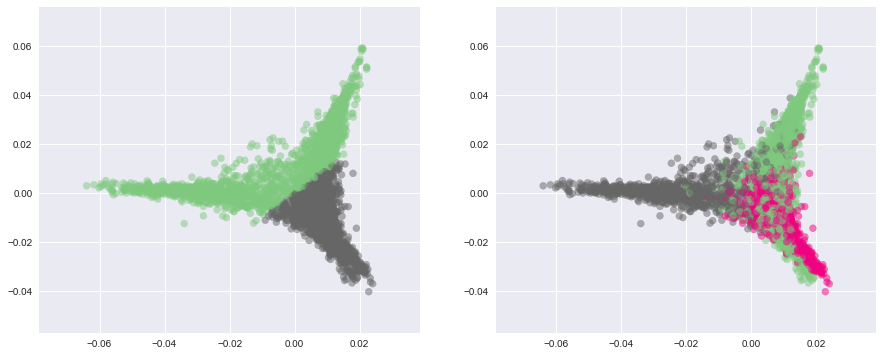

In [859]:
f, axes = plt.subplots(nrows=1, ncols=2)

for ax, lab in zip(axes.flatten(), [unsupervised_labels, labels]):
    spectral.plot_labels(eigenvectors, lab, ax=ax)

# 3D

In [860]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [861]:
init_notebook_mode(connected=True)
print(__version__)

2.2.3


In [862]:
x = eigenvectors[:, 1]
y = eigenvectors[:, 2]
z = eigenvectors[:, 3]

In [863]:
'''
x = features_pca[:, 0]
y = features_pca[:, 1]
z = features_pca[:, 2]
#''';

In [864]:
traces = []

for label in sorted(set(labels)):
    label_mask = labels == label
    #'''
    x = eigenvectors[:, 1][label_mask]
    y = eigenvectors[:, 2][label_mask]
    z = eigenvectors[:, 3][label_mask]
    '''
    x = features_pca[:, 0][label_mask]
    y = features_pca[:, 1][label_mask]
    z = features_pca[:, 2][label_mask]
    #'''
    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        name=label_to_name[label],
        mode='markers',
        marker=dict(
            size=12,
            color=i,
            #colorscale='Viridis',
            opacity=0.8
        )
    )
    
    traces.append(trace)

In [865]:
layout = go.Layout(
    hovermode= 'closest',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

In [866]:
data = traces

fig = go.Figure(data=data, layout=layout)
iplot(fig)